본 튜토리얼에서는 Penn-Fudan Database for Pedestrian Detection and Segmentation 데이터셋으로 미리 학습된 Mask R-CNN 모델을 미세조정 해 볼 것입니다. 이 데이터셋에는 보행자 인스턴스(instance, 역자주: 이미지 내에서 사람의 위치 좌표와 픽셀 단위의 사람 여부를 구분한 정보를 포함합니다.) 345명이 있는 170개의 이미지가 포함되어 있으며, 우리는 이 이미지를 사용하여 사용자 정의 데이터셋에 인스턴스 분할(Instance Segmentation) 모델을 학습하기 위해 torchvision의 새로운 기능을 사용하는 방법을 설명 할 예정입니다.

In [1]:
!pip install torchvision==0.16

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 53.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 69.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 62.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 103.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

# 데이터셋 정의하기

객체 검출, 인스턴스 분할 및 사용자 키포인트(Keypoint) 검출을 학습하기 위한 참조 스크립트를 통해 새로운 사용자 정의 데이터셋 추가를 쉽게 진행해 볼 수 있습니다. 데이터셋은 표준 torch.utils.data.Dataset 클래스를 상속 받아야 하며, __ len __ 와 __ getitem __ 메소드를 구현해 주어야 합니다.

데이터셋에서 필요한 유일한 특성은 __ getitem __ 메소드가 다음을 반환 해야 하는 것입니다:

- 이미지 : PIL(Python Image Library) 이미지의 크기 (H, W)

- 대상: 다음의 필드를 포함하는 사전 타입

    - boxes (FloatTensor[N, 4]): N 개의 바운딩 박스(Bounding box)의 좌표를 [x0, y0, x1, y1] 형태로 가집니다. x와 관련된 값 범위는 0 부터 W 이고 y와 관련된 값의 범위는 0 부터 H 까지입니다.

    - labels (Int64Tensor[N]): 바운딩 박스 마다의 라벨 정보입니다. 0 은 항상 배경의 클래스를 표현합니다.

    - image_id (Int64Tensor[1]): 이미지 구분자입니다. 데이터셋의 모든 이미지 간에 고유한 값이어야 하며 평가 중에도 사용됩니다.

    - area (Tensor[N]): 바운딩 박스의 면적입니다. 면적은 평가 시 작음,중간,큰 박스 간의 점수를 내기 위한 기준이며 COCO 평가를 기준으로 합니다.

    - iscrowd (UInt8Tensor[N]): 이 값이 참일 경우 평가에서 제외합니다.

    - (선택적) masks (UInt8Tensor[N, H, W]): N 개의 객체 마다의 분할 마스크 정보입니다.

    - (선택적) keypoints (FloatTensor[N, K, 3]): N 개의 객체마다의 키포인트 정보입니다. 키포인트는 [x, y, visibility] 형태의 값입니다. visibility 값이 0인 경우 키포인트는 보이지 않음을 의미합니다. 데이터 증강(Data augmentation)의 경우 키포인트 좌우 반전의 개념은 데이터 표현에 따라 달라지며, 새로운 키포인트 표현에 대해 《references/detection/transforms.py》 코드 부분을 수정 해야 할 수도 있습니다.

모델이 위의 방법대로 리턴을 하면, 학습과 평가 둘 다에 대해서 동작을 할 것이며 평가 스크립트는 pip install pycocotools` 로 설치 가능한 pycocotools 를 사용하게 될 것입니다.

## labels 에 대한 참고사항.

이 모델은 클래스 0 을 배경으로 취급합니다. 만약 준비한 데이터셋에 배경의 클래스가 없다면, labels 에도 0 이 없어야 합니다. 예를 들어, 고양이 와 강아지 의 오직 2개의 클래스만 분류한다고 가정하면, (0 이 아닌) 1 이 고양이 를, 2 가 강아지 를 나타내도록 정의해야 합니다. 따라서, 이 예시에서, 어떤 이미지에 두 개의 클래스가 모두 있다면, labels 텐서는 [1,2] 와 같은 식이 되어야 합니다.

추가로, 학습 중에 가로 세로 비율 그룹화를 사용하려는 경우(각 배치에 유사한 가로 세로 비율이 있는 영상만 포함되도록), 이미지의 넓이, 높이를 리턴할 수 있도록 get_height_and_width 메소드를 구현하기를 추천합니다. 이 메소드가 구현되지 않은 경우에는 모든 데이터셋은 __ getitem __ 를 통해 메모리에 이미지가 로드되며 사용자 정의 메소드를 제공하는 것보다 느릴 수 있습니다.

## PennFudan를 위한 사용자 정의 데이터셋 작성하기

    PennFudanPed/
      PedMasks/
        FudanPed00001_mask.png
        FudanPed00002_mask.png
        FudanPed00003_mask.png
        FudanPed00004_mask.png
        ...
      PNGImages/
        FudanPed00001.png
        FudanPed00002.png
        FudanPed00003.png
        FudanPed00004.png

한 쌍의 영상과 분할 마스크의 한 가지 예는 다음과 같습니다.

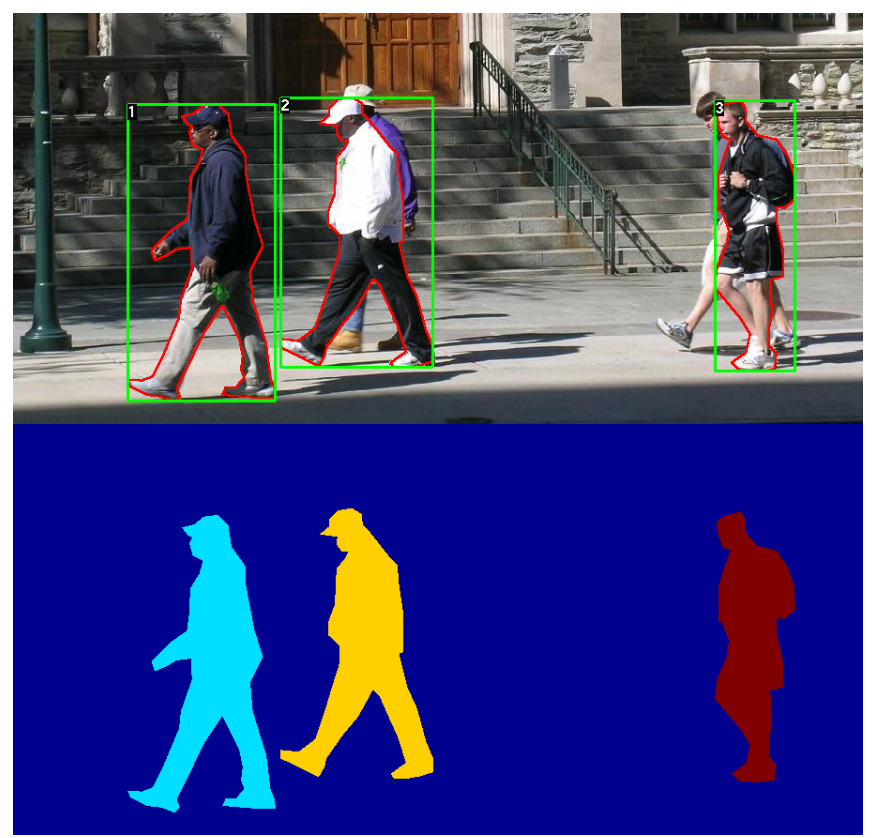

각 이미지에는 해당하는 분할 마스크가 있으며, 여기서 각각의 색상은 다른 인스턴스에 해당합니다. 데이터셋에 해당하는 torch.utils.data.Dataset` 클래스를 작성합시다.

In [50]:
import os
import numpy as np
import torch
from PIL import Image


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # 모든 이미지 파일들을 읽고, 정렬하여
        # 이미지와 분할 마스크 정렬을 확인합니다
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # 이미지와 마스크를 읽어옵니다
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # 분할 마스크는 RGB로 변환하지 않음을 유의하세요
        # 왜냐하면 각 색상은 다른 인스턴스에 해당하며, 0은 배경에 해당합니다
        mask = Image.open(mask_path)
        # numpy 배열을 PIL 이미지로 변환합니다
        mask = np.array(mask)
        # 인스턴스들은 다른 색들로 인코딩 되어 있습니다.
        obj_ids = np.unique(mask)
        # 첫번째 id 는 배경이라 제거합니다
        obj_ids = obj_ids[1:]

        # 컬러 인코딩된 마스크를 바이너리 마스크 세트로 나눕니다
        masks = mask == obj_ids[:, None, None]

        # 각 마스크의 바운딩 박스 좌표를 얻습니다
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # 모든 것을 torch.Tensor 타입으로 변환합니다
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # 객체 종류는 한 종류만 존재합니다(역자주: 예제에서는 사람만이 대상입니다)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # 모든 인스턴스는 군중(crowd) 상태가 아님을 가정합니다
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [28]:
import os
import torch

import numpy as np

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

class PennFudanDataset(torch.utils.data.Dataset):

    def __init__(self, root, transforms):

        self.root = root
        self.transforms = transforms

        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, 'PNGImages'))))
        self.masks = list(sorted(os.listdir(os.path.join(root, 'PedMasks'))))

    def __getitem__(self,idx):
        # load images and masks
        img_path = os.path.join(self.root, 'PNGImages', self.imgs[idx])
        mask_path  = os.path.join(self.root, 'PedMasks', self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)

        # 인스턴스들은 다른 색들로 인코딩 되어 있습니다.
        obj_ids = torch.unique(mask)
        # 첫번째 id 는 배경이라 제거합니다
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype = torch.uint8)

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype = torch.float32)

        #boxes = masks_to_boxes(masks)

        # there is only one class (역자주: 예제에서는 사람만이 대상입니다)
        labels = torch.ones((num_objs,), dtype = torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:,1]) * (boxes[:,2] - boxes[:,0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype = torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        #img = tv_tensors.image(img)

        target = {}
        #target['boxes'] = tv_tensors.BoundingBoxes(boxes, format = 'XYXY', canvas_size = F.get_size(img))
        target['boxes'] = boxes
        #target['masks'] = tv_tensors.Mask(masks)
        target['masks'] = masks
        target['labels'] = labels
        target['image_id'] = image_id
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):

        return len(self.imgs)


# 모델 정의하기

이번 튜토리얼에서는 Faster R-CNN 에 기반한 Mask R-CNN 모델을 사용할 예정입니다. Faster R-CNN은 이미지에 존재할 수 있는 객체에 대한 바운딩 박스와 클래스 점수를 모두 예측하는 모델입니다.

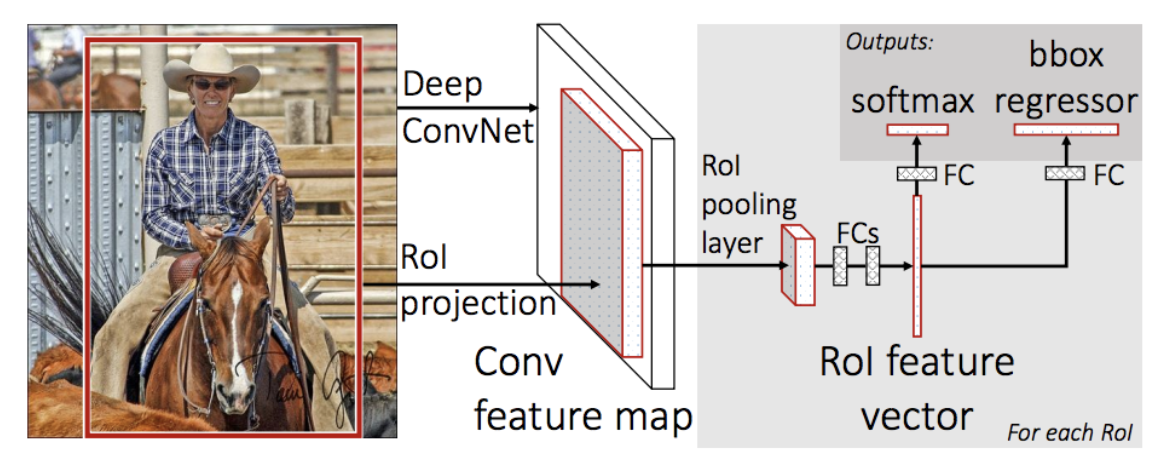

Mask R-CNN은 각 인스턴스에 대한 분할 마스크 예측하는 추가 분기(레이어)를 Faster R-CNN에 추가한 모델입니다.

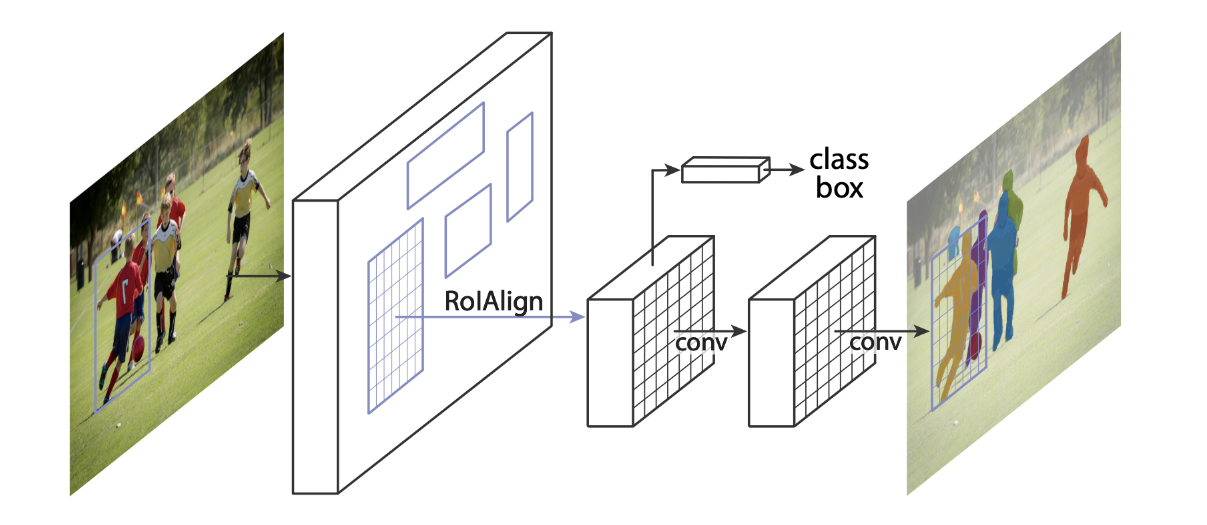

Torchvision 모델주(model zoo, 역자주:미리 학습된 모델들을 모아 놓은 공간)에서 사용 가능한 모델들 중 하나를 이용해 모델을 수정하려면 보통 두가지 상황이 있습니다. 첫 번째 방법은 미리 학습된 모델에서 시작해서 마지막 레이어 수준만 미세 조정하는 것입니다. 다른 하나는 모델의 백본을 다른 백본으로 교체하는 것입니다.(예를 들면, 더 빠른 예측을 하려고 할때) (역자주: 백본 모델을 ResNet101 에서 MobilenetV2 로 교체하면 수행 속도 향상을 기대할 수 있습니다. 대신 인식 성능은 저하 될 수 있습니다.)

# 1 - 미리 학습된 모델로부터 미세 조정

COCO에 대해 미리 학습된 모델에서 시작하여 특정 클래스를 위해 미세 조정을 원한다고 가정해 봅시다. 아래와 같은 방법으로 가능합니다:

In [3]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# COCO로 미리 학습된 모델 읽기
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights = 'DEFAULT')

# 분류기를 새로운 것으로 교체하는데, num_classes는 사용자가 정의합니다
num_classes = 2 # 1 class(사람) + 배경

# 분류기에서 사용할 입력 특징의 차원 정보를 얻습니다
in_features = model.roi_heads.box_predictor.cls_score.in_features

# 미리 학습된 모델의 머리 부분을 새로운 것으로 교체합니다
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 93.2MB/s]


2 - 다른 백본을 추가하도록 모델을 수정하기

In [6]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# 분류 목적으로 미리 학습된 모델을 로드하고 특징들만을 리턴하도록 합니다
backbone = torchvision.models.mobilenet_v2(weights = 'DEFAULT').features

# Faster RCNN은 백본의 출력 채널 수를 알아야 합니다.
# mobilenetV2의 경우 1280이므로 여기에 추가해야 합니다.
backbone.out_channels = 1280

# RPN(Region Proposal Network)이 5개의 서로 다른 크기와 3개의 다른 측면 비율(Aspect ratio)을 가진
# 5 x 3개의 앵커를 공간 위치마다 생성하도록 합니다.
# 각 특징 맵이 잠재적으로 다른 사이즈와 측면 비율을 가질 수 있기 때문에 Tuple[Tuple[int]] 타입을 가지도록 합니다.

anchor_generator = AnchorGenerator(sizes = ((32, 64, 128, 256, 512),),
                                   aspect_ratios = ((0.5, 1.0, 2.0),))

# 관심 영역의 자르기 및 재할당 후 자르기 크기를 수행하는 데 사용할 피쳐 맵을 정의합니다.
# 만약 백본이 텐서를 리턴할때, featmap_names 는 [0] 이 될 것이라고 예상합니다.
# 일반적으로 백본은 OrderedDict[Tensor] 타입을 리턴해야 합니다.
# 그리고 특징맵에서 사용할 featmap_names 값을 정할 수 있습니다.

roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names = ['0'],
                                                output_size = 7,
                                                sampling_ratio = 2)

# 조각들을 Faster RCNN 모델로 합칩니다.
model = FasterRCNN(backbone,
                   num_classes = 2,
                   rpn_anchor_generator = anchor_generator,
                   box_roi_pool = roi_pooler)

# PennFudan 데이터셋을 위한 인스턴스 분할 모델

우리의 경우, 데이터 세트가 매우 작기 때문에, 우리는 1번 접근법을 따를 것이라는 점을 고려하여 미리 학습된 모델에서 미세 조정하는 방식으로 진행 하겠습니다.

여기서 인스턴스 분할 마스크도 계산하기를 원하기 때문에 Mask R-CNN를 사용합니다:

In [16]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model_instance_segmentation(num_classes):

    # COCO 에서 미리 학습된 인스턴스 분할 모델을 읽어옵니다
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights = 'DEFAULT')

    # 분류를 위한 입력 특징 차원을 얻습니다
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # 미리 학습된 헤더를 새로운 것으로 바꿉니다
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # 마스크 분류기를 위한 입력 특징들의 차원을 얻습니다
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256

    # 마스크 예측기를 새로운 것으로 바꿉니다
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model


그렇습니다. 이렇게 하면 모델 을 사용자 정의 데이터셋에서 학습하고 평가할 준비가 될 겁니다.

# 모든 것을 하나로 합치기

references/detection/ 폴더 내에 검출 모델들의 학습과 평과를 쉽게 하기 위한 도움 함수들이 있습니다. 여기서 references/detection/engine.py, references/detection/utils.py, references/detection/transforms.py 를 사용 할 것입니다. references/detection 아래의 모든 파일과 폴더들을 사용자의 폴더로 복사한 뒤 사용합니다.

데이터 증강 / 변환을 위한 도움 함수를 작성해 봅시다

In [8]:
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

0

In [43]:
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ToDtype(torch.float, scale = True))
    if train:
        # (역자주: 학습시 50% 확률로 학습 영상을 좌우 반전 변환합니다)
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [56]:
from torchvision.transforms import v2 as T

def get_transform(train):

    transforms = []

    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))

    transforms.append(T.ToDtype(torch.float, scale = True))
    transforms.append(T.ToPureTensor())

    return T.Compose(transforms)

# (선택) forward() 메소드 테스트하기

데이터셋을 반복하기 전에, 샘플 데이터로 학습과 추론 시 모델이 예상대로 동작하는지 살펴보는 것이 좋습니다.

In [44]:
import utils

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights = 'DEFAULT')

dataset = PennFudanDataset('/content/drive/MyDrive/PennFudanPed', get_transform(train = True))

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size = 2, shuffle = True, num_workers = 2,
    collate_fn = utils.collate_fn
)

In [45]:
# 학습 시
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k:v for k,v in t.items()} for t in targets]
output = model(images, targets) # Returns losses and detections

print(output)

{'loss_classifier': tensor(0.1360, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0482, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0095, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0070, grad_fn=<DivBackward0>)}


In [20]:
# 추론 시
model.eval()
x = [torch.rand(3,300,400), torch.rand(3,500,400)]
predictions = model(x) #returns predictions
print(predictions)

[{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}, {'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}]


학습(train)과 검증(validation)을 수행하도록 메인 함수를 작성합시다:

In [51]:
from engine import train_one_epoch, evaluate
import utils

# 학습을 GPU로 진행하되 GPU가 가용하지 않으면 CPU로 합니다
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# 우리 데이터셋은 두 개의 클래스만 가집니다 - 배경과 사람
num_classes = 2

# 데이터셋과 정의된 변환들을 사용합니다
dataset = PennFudanDataset('/content/drive/MyDrive/PennFudanPed', get_transform(train = True))
dataset_test = PennFudanDataset('/content/drive/MyDrive/PennFudanPed', get_transform(train = False))

# 데이터셋을 학습용과 테스트용으로 나눕니다(역자주: 여기서는 전체의 50개를 테스트에, 나머지를 학습에 사용합니다)

indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# 데이터 로더를 학습용과 검증용으로 정의합니다
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size = 2, shuffle = True, num_workers = 2,
    collate_fn = utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size = 1, shuffle = False, num_workers = 2,
    collate_fn = utils.collate_fn
)

In [52]:
# 도움 함수를 이용해 모델을 가져옵니다
model = get_model_instance_segmentation(num_classes)

# 모델을 GPU나 CPU로 옮깁니다
model.to(device)

# 옵티마이저(Optimizer)를 만듭니다
params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr = 0.005, momentum = 0.9, weight_decay = 0.0005)

# 학습률 스케쥴러를 만듭니다
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 3, gamma = 0.1)

In [53]:
num_epochs = 10

for epoch in range(num_epochs):

    # 1 에포크동안 학습하고, 10회 마다 출력합니다
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq = 10)

    # 학습률을 업데이트 합니다
    lr_scheduler.step()

    # 테스트 데이터셋에서 평가를 합니다
    evaluate(model, data_loader_test, device = device)

print("That's it!")

Epoch: [0]  [ 0/60]  eta: 0:01:12  lr: 0.000090  loss: 4.5832 (4.5832)  loss_classifier: 0.7449 (0.7449)  loss_box_reg: 0.4111 (0.4111)  loss_mask: 3.4046 (3.4046)  loss_objectness: 0.0136 (0.0136)  loss_rpn_box_reg: 0.0089 (0.0089)  time: 1.2086  data: 0.4759  max mem: 4085
Epoch: [0]  [10/60]  eta: 0:00:31  lr: 0.000936  loss: 1.9182 (2.5536)  loss_classifier: 0.4962 (0.4800)  loss_box_reg: 0.3596 (0.3113)  loss_mask: 1.1686 (1.7390)  loss_objectness: 0.0148 (0.0176)  loss_rpn_box_reg: 0.0072 (0.0057)  time: 0.6298  data: 0.0549  max mem: 4085
Epoch: [0]  [20/60]  eta: 0:00:24  lr: 0.001783  loss: 0.9465 (1.7164)  loss_classifier: 0.2405 (0.3474)  loss_box_reg: 0.2873 (0.2938)  loss_mask: 0.3813 (1.0510)  loss_objectness: 0.0160 (0.0172)  loss_rpn_box_reg: 0.0075 (0.0070)  time: 0.5805  data: 0.0118  max mem: 4085
Epoch: [0]  [30/60]  eta: 0:00:17  lr: 0.002629  loss: 0.5428 (1.3081)  loss_classifier: 0.1106 (0.2581)  loss_box_reg: 0.2040 (0.2534)  loss_mask: 0.2351 (0.7753)  loss_ob

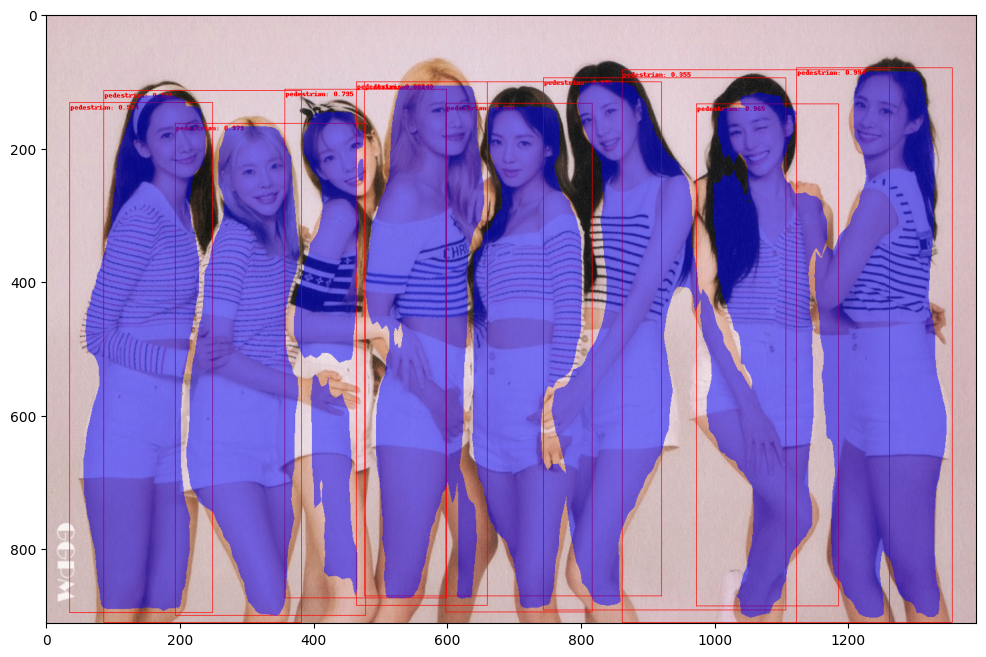

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

image = read_image('/content/gg.jpg')
eval_transform = get_transform(train = False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)

    # convert RGBA -> RGB and move to device

    x = x[:3,...].to(device)

    predictions = model([x,])
    pred = predictions[0]

image = (255.0*(image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3,...]

pred_labels = [f'pedestrian: {score:.3f}' for label, score in zip(pred['labels'], pred['scores'])]
pred_boxes = pred['boxes'].long()

output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors = 'red')

masks = (pred['masks'] > 0.7).squeeze(1)

output_image = draw_segmentation_masks(output_image, masks, alpha = 0.5, colors = 'blue')

plt.figure(figsize = (12, 12))
plt.imshow(output_image.permute(1,2,0))